<a href="https://colab.research.google.com/github/candela-ledesma/MovieClassifier-TF-DT/blob/main/IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 - Inteligencia Artificial 2024 🤖

### Comisión 3 🤩 - Ledesma Candela 🍺 Garcia Romina 🧚


---



# Carga y análisis de datos

Primero debemos importar las siguientes librerias:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.model_selection import GridSearchCV
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, Input


⚠ **ADVERTENCIA!!!** Se deben agregar manualmente los archivos movies_train.csv y movies_test.csv para el correcto funcionamiento

# Procesamiento de los datos

Acomodamos los datos eliminando filas que no tenían valoración, columnas irrelebantes y acomodando otras columnas para que pueda ser analizado correctamente.

In [ ]:
# prompt: cargar el dataset movies train

movies_train_df = pd.read_csv('/content/movies_train.csv')
movies_test_df = pd.read_csv('/content/movies_test.csv')


#combined_df = pd.concat([movies_train_df, movies_test_df], ignore_index=True)
combined_df = movies_train_df

# Separar la columna target
Y = combined_df['class'].values
X = combined_df.drop(columns = ["class"])

# Porcentajes para datos de validación y test.
test_size = 0.20
val_size = 0.10

# La función train_test_split separa los datos (X, Y) en dos porciones
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, random_state = 10)



def acomodarTabla(combined_df):
    # Eliminamos las columnas que son irrelevantes al problema
  combined_df = combined_df.drop('movieId', axis=1)
  combined_df = combined_df.drop('title', axis=1)
  combined_df = combined_df.drop('production_company_country', axis=1)
  combined_df = combined_df.drop('name_p1', axis=1)
  combined_df = combined_df.drop('name_p2', axis=1)
  combined_df = combined_df.drop('name_p3', axis=1)
  combined_df = combined_df.drop('director_name', axis=1)


  # dropeamos la columna budget porque 10271/13000 tienen budget en 0
  combined_df = combined_df.drop('budget', axis=1)

  # hacemos un mappeo de la columna belong to collection para que true sea 1 y false 0
  combined_df['belong_to_collection'] = combined_df['belong_to_collection'].map({True: 1, False: 0})


  # dropeamos la columna revenue porque 9932/13000 tienen revenue en 0
  combined_df = combined_df.drop('revenue', axis=1)

  combined_df = pd.get_dummies(combined_df, columns=['genre'], prefix=['genre'], dtype = int)


  # Obtenemos el valor promedio de la columna 'runtime' (numérico)
  average_runtime = round(combined_df['runtime'].mean())

  # Usando el valor anterior, completamos los valores nulos de la columna 'runtime'.
  combined_df['runtime'] = combined_df['runtime'].fillna(average_runtime)

  # Obtenemos el valor promedio de la columna 'director_popularity' (numérico)
  average_director_popularity = round(combined_df['director_popularity'].mean())

  # Usando el valor anterior, completamos los valores nulos de la columna 'director_popularity'.
  combined_df['director_popularity'] = combined_df['director_popularity'].fillna(average_director_popularity)

  # Calculamos el promedio de populariadad de cada companía
  company_avg_popularity = combined_df.groupby('production_company_name')['popularity'].mean()

  # Creamos una nueva columna para que en vez del dato del nombre de la companía tenga un dato numérico que es la popularidad de esta
  combined_df['avg_company_popularity'] = combined_df['production_company_name'].map(company_avg_popularity)

  # dropeamos la columna 'production_company_name'
  combined_df = combined_df.drop('production_company_name', axis=1)
  return combined_df


#Aplicamos los cambios anteriores a cada parte del dataset por separado para que el promedio se calcule solo con los datos que se conocen
X_train = acomodarTabla(X_train)
X_val = acomodarTabla(X_val)
X_test = acomodarTabla(X_test)

X_FinalTest = acomodarTabla(movies_test_df)

combined_df.head()

X_train.info()

# MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))

# Escalamos los datos para que no haya tanta diferencia entre las columnas
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
X_FinalTest = scaler.fit_transform(X_FinalTest)


<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 3275 to 418
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   belong_to_collection    9000 non-null   int64  
 1   popularity              9000 non-null   float64
 2   runtime                 9000 non-null   float64
 3   popularity_p1           9000 non-null   float64
 4   number_movies_p1        9000 non-null   int64  
 5   popularity_movies_p1    9000 non-null   float64
 6   popularity_p2           9000 non-null   float64
 7   number_movies_p2        9000 non-null   int64  
 8   popularity_movies_p2    9000 non-null   float64
 9   popularity_p3           9000 non-null   float64
 10  number_movies_p3        9000 non-null   int64  
 11  popularity_movies_p3    9000 non-null   float64
 12  director_popularity     9000 non-null   float64
 13  genre_Action            9000 non-null   int64  
 14  genre_Adventure         9000 non-null   int

# Desarrollo de un Árbol de Decisión

Utilizando los datos acomodados creamos un árbol de desición con los siguientes parámetros que resultaron ser los mejores despues de varias pruebas.

In [ ]:
# Creamos un árbol de decisión (AD)
clf = DecisionTreeClassifier(max_depth = 11, criterion= "entropy", min_samples_split= 120)

# Se ajusta el AD con los datos de entrenamiento
clf = clf.fit(X_train, y_train)


print("Accuracy sobre conjunto de train:", clf.score(X_train, y_train))

print("Accuracy sobre conjunto de test:", clf.score(X_test, y_test))

# Predicciones sobre el conjunto de test
predictionsDT = clf.predict(X_test)

print("Accuracy sobre conjunto de test:", accuracy_score(y_test, predictionsDT))
print()

print(classification_report(y_test, predictionsDT))

Accuracy sobre conjunto de train: 0.7386666666666667
Accuracy sobre conjunto de test: 0.6288
Accuracy sobre conjunto de test: 0.6288

              precision    recall  f1-score   support

       Buena       0.60      0.70      0.65      1160
        Mala       0.73      0.68      0.70       938
   Muy buena       0.43      0.30      0.35       402

    accuracy                           0.63      2500
   macro avg       0.59      0.56      0.57      2500
weighted avg       0.62      0.63      0.62      2500



# Desarrollo de una Red Neuronal Artificial

In [ ]:
# Onehot encoder
enc = OneHotEncoder()

# El encoder define un mapeo para las etiquetas.
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_enc = enc.transform(y_val.reshape(-1, 1)).toarray() # Aquí usar transform.
y_test_enc = enc.transform(y_test.reshape(-1, 1)).toarray() # Aquí usar transform.

print("Mapeo del encoder:")
pd.DataFrame({
    c : enc.transform([[c]]).toarray()[0]
    for c in list(enc.categories_[0])
})

Mapeo del encoder:


,Buena,Mala,Muy buena
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [ ]:

# Definimos el modelo usando la función de pérdida balanceada
def define_model_with_balanced_loss(num_features, num_outputs):
    model = Sequential()

    # Capa de entrada de la red
    model.add(Input(shape=(num_features, )))

    model.add(layers.Dense(64, activation = 'tanh'))
    model.add(layers.Dense(112, activation = 'relu'))
    model.add(layers.Dense(16, activation = 'tanh'))
    model.add(layers.Dense(176, activation = 'sigmoid'))
    model.add(layers.Dense(144, activation = 'tanh'))

    # Capa de salida de la red
    model.add(layers.Dense(num_outputs, activation = 'softmax'))

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

eps = 32
bs = 32

num_features = X_train.shape[1] ## cantidad de atributos en X_train y X_val
num_outputs = y_train_enc.shape[1] ## cantidad de categorías posibles (4 géneros musicales)

# Crear el modelo con la función de pérdida balanceada
model = define_model_with_balanced_loss(num_features, num_outputs)

# Entrenar el modelo con la función de pérdida balanceada
history = model.fit(X_train, y_train_enc, batch_size = bs, epochs = eps, validation_data=(X_val, y_val_enc))


Epoch 1/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4744 - loss: 1.0297 - val_accuracy: 0.4940 - val_loss: 0.9838
Epoch 2/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5054 - loss: 0.9880 - val_accuracy: 0.5300 - val_loss: 0.9592
Epoch 3/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5110 - loss: 0.9666 - val_accuracy: 0.5420 - val_loss: 0.9602
Epoch 4/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5372 - loss: 0.9518 - val_accuracy: 0.5630 - val_loss: 0.9283
Epoch 5/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5277 - loss: 0.9517 - val_accuracy: 0.5730 - val_loss: 0.9189
Epoch 6/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5455 - loss: 0.9361 - val_accuracy: 0.4830 - val_loss: 1.0807
Epoch 7/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5461 - loss: 0.9354 - val_accuracy: 0.4740 - val_loss: 1.0471
Epoch 8/32
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5489 - loss: 0.9351 - val_accuracy: 0.

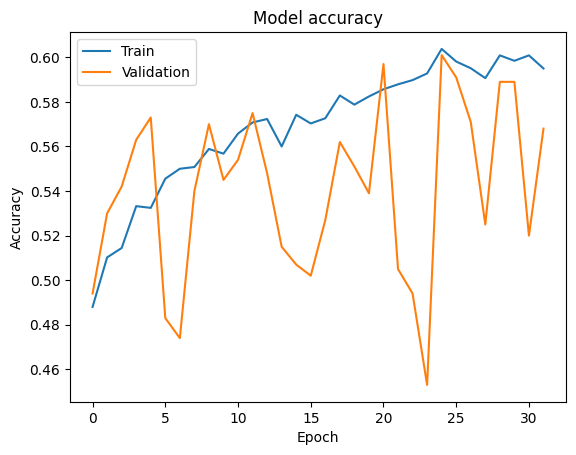

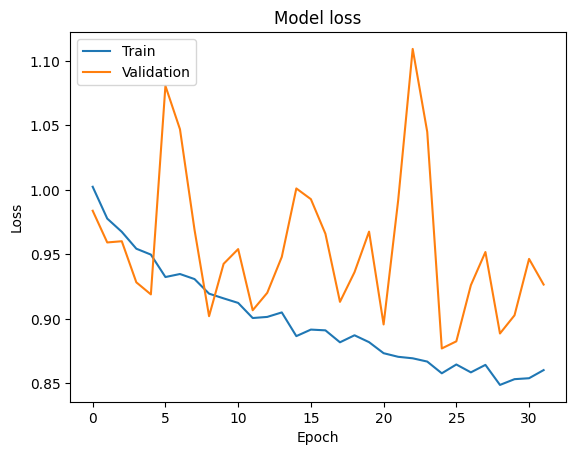

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Predicciones sobre el conjunto de validación
predictionsTest = model.predict(X_test)

print("rtados de test")
# Reporte de clasificación
print(classification_report(np.argmax(y_test_enc, axis = 1),
                            np.argmax(predictionsTest, axis = 1),
                            target_names = enc.categories_[0]))

predictionsTrain = model.predict(X_train)
print("rtados de train")
# Reporte de clasificación
print(classification_report(np.argmax(y_train_enc, axis = 1),
                            np.argmax(predictionsTrain, axis = 1),
                            target_names = enc.categories_[0]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
rtados de test
              precision    recall  f1-score   support

       Buena       0.58      0.65      0.62      1160
        Mala       0.61      0.66      0.64       938
   Muy buena       0.50      0.23      0.32       402

    accuracy                           0.59      2500
   macro avg       0.57      0.52      0.52      2500
weighted avg       0.58      0.59      0.58      2500

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
rtados de train
              precision    recall  f1-score   support

       Buena       0.61      0.69      0.64      4157
        Mala       0.61      0.69      0.65      3458
   Muy buena       0.69      0.22      0.33      1385

    accuracy                           0.61      9000
   macro avg       0.64      0.53      0.54      9000
weighted avg       0.62      0.61      0.60      9000



In [ ]:

tree_predictions = clf.predict(X_FinalTest)
nn_predictions = model.predict(X_FinalTest)
nn_predictions = np.argmax(nn_predictions, axis=1)

class_labels = ['Buena', 'Mala', 'Muy buena']
nn_predictions = [class_labels[i] for i in nn_predictions]


test_copy = movies_test_df.copy()


test_copy['tree_predictions'] = tree_predictions
test_copy['nn_predictions'] = nn_predictions


test_copy.to_csv('test_with_predictions.csv', index=False)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
!git clone https://github.com/candela-ledesma/MovieClassifier-TF-DT.git